# **<p style="text-align: center;">Проверка гипотез. </p>**

![**Сервис аренды самокатов GoFast**](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQRSM-MhBnCKx4CkkzPLAahXMUCG5abeMpOGg&usqp=CAU)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
from scipy.special import comb
from scipy.stats import norm
import scipy.stats as st
from scipy import stats
from scipy.stats import ttest_ind

## Загрузка данных

In [2]:
df_users_go = pd.read_csv('/datasets/users_go.csv')
df_users_go.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [3]:
df_users_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [4]:
df_rides_go = pd.read_csv('/datasets/rides_go.csv')
df_rides_go.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [5]:
df_rides_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [6]:
df_subscriptions_go = pd.read_csv('/datasets/subscriptions_go.csv')
df_subscriptions_go

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [7]:
df_subscriptions_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


***Загрузили основные данные с информацией о пользователях, их поездках и подписках. Вывели первые строки каждого набора данных. Изучили общую информацию о каждом датафрейме,пропущенные значения в столбцах отсутствуют.***


## Предобработка данных

### Приведем столбец date к типу даты pandas.

In [8]:
df_rides_go['date'] = pd.to_datetime(df_rides_go['date'],format='%Y-%m-%d')
df_rides_go.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [9]:
df_rides_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


### Создадим новый столбец с номером месяца на основе столбца date.

In [10]:
df_rides_go['month_rides'] = df_rides_go['date'].dt.month
df_rides_go.head()

,user_id,distance,duration,date,month_rides
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


In [11]:
df_rides_go['date'] = pd.to_datetime(df_rides_go['date']).dt.date

min_date = df_rides_go['date'].min()
max_date = df_rides_go['date'].max()

print('Период данных:', min_date, 'до', max_date)

Период данных: 2021-01-01 до 2021-12-30


Проверим данные за какой период у нас имеются. Данные о сервисе аренды самокатов GoFast представленны за 2021 год.✔

In [12]:
df_rides_go.columns

Index(['user_id', 'distance', 'duration', 'date', 'month_rides'], dtype='object')

### Проверим наличие пропущенных значений и дубликатов в датафреймах. Обработаем их, если такие значения присутствуют.

In [13]:
duplicate_rows = df_users_go[df_users_go.duplicated ()]
duplicate_rows

,user_id,name,age,city,subscription_type
1534,293,Агата,26,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
1536,909,Константин,20,Екатеринбург,free
1537,403,Полина,19,Сочи,ultra
1538,908,Рустам,30,Тюмень,free
1539,43,Стефания,22,Омск,ultra
1540,127,Павел,25,Пятигорск,ultra
1541,659,Злата,27,Ростов-на-Дону,ultra
1542,204,Руслан,30,Пятигорск,ultra
1543,153,Герман,23,Москва,ultra


In [14]:
duplicate_rows.count()

user_id              31
name                 31
age                  31
city                 31
subscription_type    31
dtype: int64

In [15]:
df_users_go.loc[((df_users_go['user_id'] == 293) &(df_users_go['name' ] == 'Агата'))]

,user_id,name,age,city,subscription_type
292,293,Агата,26,Краснодар,ultra
1534,293,Агата,26,Краснодар,ultra


In [16]:
df_users_go = df_users_go.drop_duplicates()
duplicate_rows_drop = df_users_go[df_users_go.duplicated ()]
duplicate_rows_drop.count()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

***Изучили общую информацию о каждом датафрейме,пропущенные значения в столбцах отсутствуют. Найден  31 дубликат в датафреймах,данные дубликаты удалили.***

## Исследовательский анализ данных

### Опишем и визуализируем общую информацию о пользователях и поездках: частота встречаемости городов.

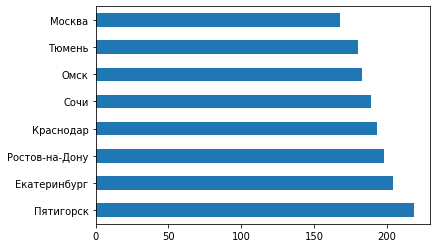

In [17]:
city_frequency= df_users_go['city'].value_counts()
city_frequency.plot(kind='barh');

In [18]:
city_frequency = df_users_go['city'].value_counts().reset_index()
city_frequency.columns = ['Город', 'Количество пользователей']
city_frequency = city_frequency.sort_values(by='Количество пользователей', ascending=False)
print(city_frequency)

            Город  Количество пользователей
0       Пятигорск                       219
1    Екатеринбург                       204
2  Ростов-на-Дону                       198
3       Краснодар                       193
4            Сочи                       189
5            Омск                       183
6          Тюмень                       180
7          Москва                       168


<Figure size 864x576 with 0 Axes>

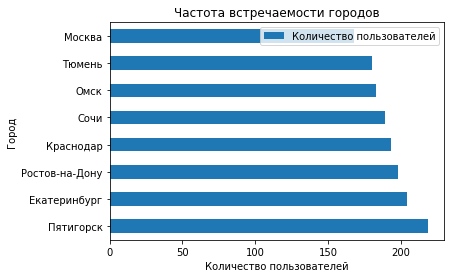

In [19]:
plt.figure(figsize=(12, 8))
city_frequency.plot(kind='barh', x='Город', y='Количество пользователей')

plt.xlabel('Количество пользователей')
plt.ylabel('Город')
plt.title('Частота встречаемости городов')
plt.show()

Исходя из предоставленной информации о количестве пользователей сервиса аренды самокатов GoFast в разных городах, можно сделать следующие выводы:
    
 - Пятигорск является наиболее популярным городом среди пользователей GoFast, с 219 пользователями.
 - Екатеринбург занимает второе место по популярности с 204 пользователями.
 - Ростов-на-Дону, Краснодар, Сочи, Омск, Тюмень и Москва также имеют значительное количество пользователей, хотя и ниже по сравнению с Пятигорском и Екатеринбургом.
    
Можно заключить, что сервис аренды самокатов GoFast пользуется спросом в разных городах, и, вероятно, есть потенциал для расширения и увеличения покрытия в других городах. ✔

### Опишем и визуализируем общую информацию о пользователях и поездках: соотношение пользователей с подпиской и без подписки

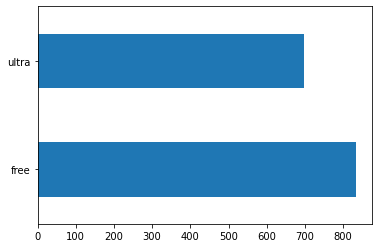

In [20]:
subscription_type_ratio = df_users_go['subscription_type'].value_counts()
subscription_type_ratio.plot(kind='barh');

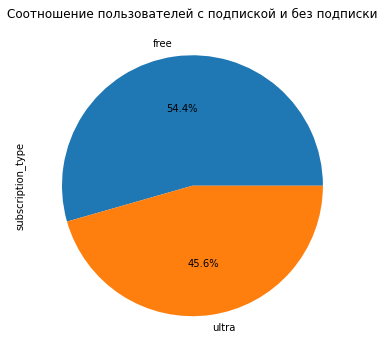

In [21]:
# Получение количества пользователей с подпиской и без подписки
subscription_type_ratio = df_users_go['subscription_type'].value_counts()

# Создание круговой диаграммы
plt.figure(figsize=(6, 6))
subscription_type_ratio.plot.pie(autopct='%1.1f%%')

# Подпись диаграммы
plt.title('Соотношение пользователей с подпиской и без подписки')

# Отображение диаграммы
plt.show()

Исходя из предоставленных данных о соотношении пользователей с подпиской Ultra и без подписки, можно сделать следующие выводы:
    
- Большинство пользователей (54,4%) не имеют подписки на сервис аренды самокатов GoFast.
- Пользователи с подпиской Ultra составляют 45,6% от общего числа пользователей.

Эти данные могут указывать на потенциал для увеличения числа пользователей с подпиской. Бизнесу может быть выгодно провести дополнительные маркетинговые и промоциональные мероприятия, чтобы привлечь больше пользователей к использованию подписки и повысить ее привлекательность. ✔

### Опишем и визуализируем общую информацию о пользователях и поездках: возраст пользователей.

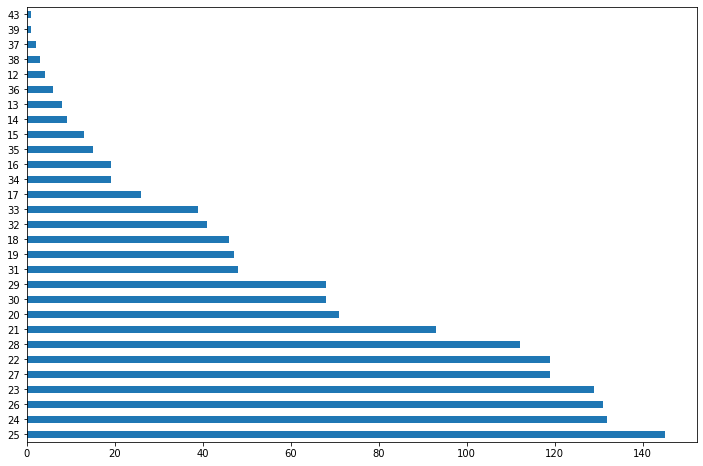

In [22]:
users_age = df_users_go['age'].value_counts()
users_age.plot(kind='barh', figsize=(12,8));

***Что касается возраста пользователей сервиса аренды самокатов GoFast, прослеживается высокая разница в возрасте. Активнее всего сервисом пользуются клиенты в возрасте 25 лет. Скачек пользовательской активности в диапазоне 25-31 год. В возрастном диапазоне 34 года и старше пользователи редко пользуются данным сервисом.Так же встречается возраст 12 -16 лет,клиентов этого возраста мало,тк данный возрастной диапазон ограничен требованиями компании по возрастному диапазону использования данного сервиса.***

In [23]:
df_users_go['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

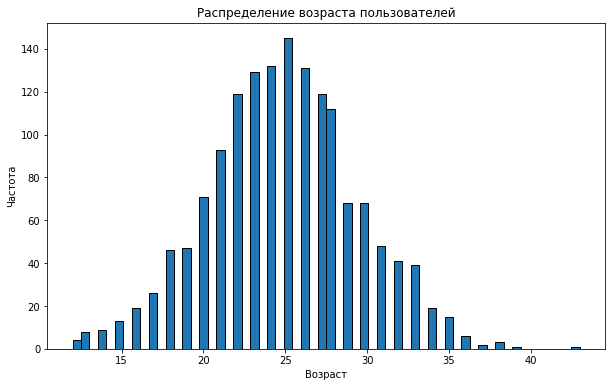

In [25]:
plt.figure(figsize=(10, 6))
df_users_go['age'].plot.hist(bins=60, edgecolor='black')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.title('Распределение возраста пользователей')
plt.show()

Исходя из этих данных, можно сделать вывод, что большинство пользователей сервиса аренды самокатов GoFast находятся в возрастном диапазоне от 20 до 30 лет. Однако также есть пользователи моложе 20 лет и старше 30 лет, что указывает на разнообразие возрастных групп пользователей. Эта информация может быть полезной для определения целевой аудитории и разработки маркетинговых стратегий, учитывающих возрастные особенности пользователей. 

### Опишем и визуализируем общую информацию о пользователях и поездках: расстояние, которое пользователь преодолел за одну поездку.

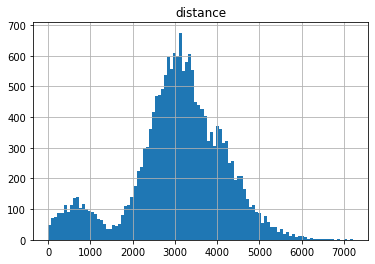

In [26]:
df_rides_go.hist('distance', bins=100);

***Пользователи сервиса аренды самокатов GoFast проезжают чаще всего растояние 3,2 км. Сервис активно используют проезжая 2,5-3,5 км - это расстояние,исходя из пользовательских предпочтений, оптимальное для аренды самокатов.***

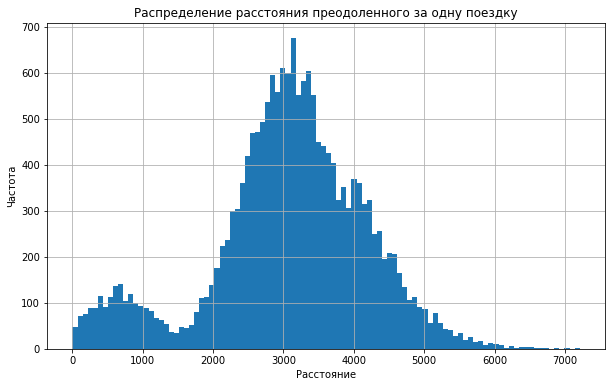

In [27]:
plt.figure(figsize=(10, 6))
df_rides_go['distance'].plot.hist(bins=100)
plt.grid(True)
plt.xlabel('Расстояние')
plt.ylabel('Частота')
plt.title('Распределение расстояния преодоленного за одну поездку')
plt.show()

В гистограмме распределения расстояний за одну поездку наблюдаются два пика в районе 500 метров и 3,3 километров, можно предположить следующие объяснения:
- существуют два основных типа поездок. Первый пик в районе 500 метров может соответствовать коротким поездкам в пределах одного квартала или района. Второй пик в районе 3,3 километров может указывать на более длительные поездки, возможно, между различными районами города или для достижения конкретных мест назначения.
- пользователи могут иметь привычку совершать поездки на определенное расстояние. Например, некоторые могут использовать самокаты для покрытия коротких расстояний вокруг своего дома или работы, что приводит к появлению первого пика. В то же время, другие могут предпочитать совершать более длительные поездки, что приводит к появлению второго пика.
- географические факторы: Расстояние может быть также связано с географическими особенностями города или региона. Например, если сервис аренды самокатов популярен в центральной части города, то короткие поездки в этой области могут доминировать, что приводит к появлению первого пика. С другой стороны, поездки на более дальние расстояния могут быть связаны с достопримечательностями или другими интересными местами, что приводит к появлению второго пика.

В целом, анализ расстояний и их распределения может предоставить полезную информацию о поведении пользователей и позволить адаптировать сервис аренды самокатов под их потребности. 

### Опишем и визуализируем общую информацию о пользователях и поездках: продолжительность поездок.

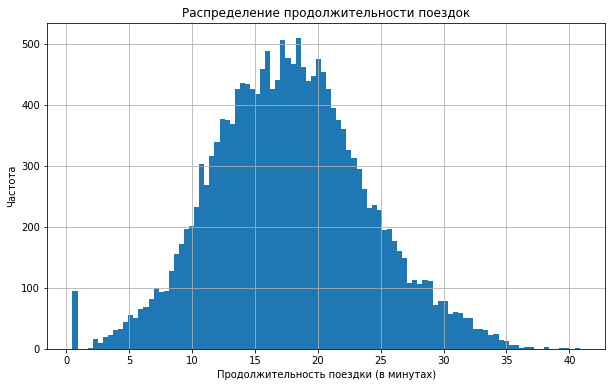

In [29]:
plt.figure(figsize=(10, 6))
df_rides_go['duration'].plot.hist(bins=100, grid=True)
plt.xlabel('Продолжительность поездки (в минутах)')
plt.ylabel('Частота')
plt.title('Распределение продолжительности поездок')
plt.show()

Пик около значения 0 на гистограмме продолжительности поездок может быть связан с несколькими возможными факторами:

- Ошибки или неточности данных: Может быть, в наборе данных есть ошибки или неточности, которые приводят к появлению поездок с очень маленькой или нулевой продолжительностью. Это может быть вызвано ошибками в записи данных или аномальными значениями.
- Технические причины: Пики около 0 могут также быть связаны с техническими аспектами системы аренды самокатов. Например, система может регистрировать короткие периоды времени, когда самокат не двигается или стоит на месте, как отдельные поездки с продолжительностью близкой к нулю.

In [30]:
df_rides_go['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Средняя продолжительность поездки составляет примерно 17.8 минут.
Стандартное отклонение продолжительности поездок равно 6 минут.
Минимальная продолжительность поездки составляет 0.5 минуты, что может быть связано с кратковременными поездками или ошибками в данных.
25% поездок имеют продолжительность менее 13.6 минут, а 75% поездок имеют продолжительность менее 21.72 минут. Это указывает на наличие разнообразия продолжительности поездок.
Максимальная продолжительность поездки составляет 40.82 минуты, что может быть связано с длительными поездками или выбросами в данных.

## Объединение данных

### Объединим данные о пользователях, поездках и подписках в один датафрейм. Для этого воспользуемся методом merge().

In [31]:
data = df_users_go.merge(df_rides_go,on='user_id').merge(df_subscriptions_go,on='subscription_type')
data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month_rides,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [32]:
print("Размерность объединенного датафрейма:", data.shape)
print("Размерность исходного датафрейма df_users_go:", df_users_go.shape)
print("Размерность исходного датафрейма df_rides_go:", df_rides_go.shape)
print("Размерность исходного датафрейма df_subscriptions_go:", df_subscriptions_go.shape)

Размерность объединенного датафрейма: (18068, 12)
Размерность исходного датафрейма df_users_go: (1534, 5)
Размерность исходного датафрейма df_rides_go: (18068, 5)
Размерность исходного датафрейма df_subscriptions_go: (2, 4)


Проверим размерность полученной таблицы и сравним ее с размерностью таблиц до объединения. Убедимся что мы ничего не потеряли.

### Создадим ещё два датафрейма из датафрейма:c данными о пользователях без подписки;с данными о пользователях с подпиской.

In [33]:
data_subscription_ultra = data.loc[(data['subscription_type'] == 'ultra')]
data_subscription_ultra

,user_id,name,age,city,subscription_type,distance,duration,date,month_rides,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,3973.046497,24.671163,2021-08-29,8,6,0,199
6496,699,Оксана,22,Москва,ultra,3288.702563,15.892886,2021-09-12,9,6,0,199
6497,699,Оксана,22,Москва,ultra,3076.159348,14.389525,2021-09-26,9,6,0,199
6498,699,Оксана,22,Москва,ultra,4707.845501,15.839579,2021-10-17,10,6,0,199


In [34]:
data_subscription_free = data.loc[(data['subscription_type'] == 'free')]
data_subscription_free

,user_id,name,age,city,subscription_type,distance,duration,date,month_rides,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


###  Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

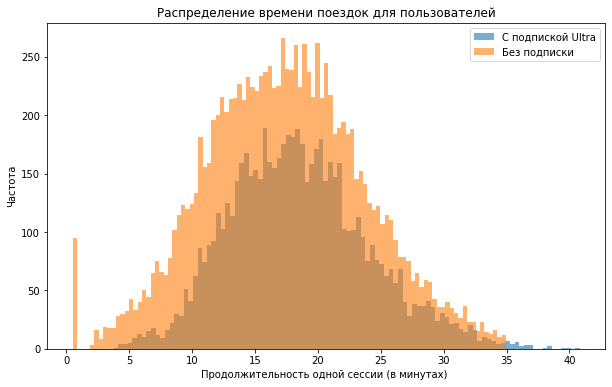

In [38]:
plt.figure(figsize=(10, 6))
plt.hist(data_subscription_ultra['duration'], bins=100, alpha=0.6, label='С подпиской Ultra')
plt.hist(data_subscription_free['duration'], bins=100, alpha=0.6, label='Без подписки')
plt.xlabel('Продолжительность одной сессии (в минутах) ')
plt.ylabel('Частота')
plt.title('Распределение времени поездок для пользователей')
plt.legend()
plt.show()


Распределения для обеих групп пользователей объединим для наглядности, наложив их друг на друга. Заметим,что пик около 0 наблюдается в данных без подписки,это может свидетельствовать о том,что пользователь тратит время на изучение приложения по использованию самоката,в этот момент самокат стоит на месте и программа фиксирует эти показания как 0,либо пользователь совершает попытки сменить самокат. 


## Подсчёт выручки

###  Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными: найдем  суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [39]:
data['rounded_duration'] = np.ceil(data['duration']).astype(int)
data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month_rides,minute_price,start_ride_price,subscription_fee,rounded_duration
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199,26
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199,16
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199,7
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199,19
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199,27


Перед построением сводной таблицы и расчетом выручки длительность каждой поездки округлим до целой минуты(до следующего целого числа). ✔


In [40]:
sum_distance = data.groupby(['user_id', 'month_rides', 'subscription_type']).agg({'distance': ['sum']}). reset_index()
sum_distance.head()

,user_id,month_rides,subscription_type,distance
,,,,sum
0,1,1,ultra,7027.511294
1,1,4,ultra,754.159807
2,1,8,ultra,6723.470560
3,1,10,ultra,5809.911100
4,1,11,ultra,7003.499363


In [41]:
count_duration = data.groupby(['user_id', 'month_rides', 'subscription_type']).agg({'duration': ['count']}). reset_index()
count_duration.columns = ['user_id', 'month_rides', 'subscription_type', 'duration_count']
count_duration.head()

,user_id,month_rides,subscription_type,duration_count
0,1,1,ultra,2
1,1,4,ultra,1
2,1,8,ultra,2
3,1,10,ultra,2
4,1,11,ultra,3


In [42]:
sum_duration = data.groupby(['user_id', 'month_rides', 'subscription_type']).agg({'duration': ['sum']}). reset_index()
sum_duration.columns = ['user_id', 'month_rides', 'subscription_type', 'duration_sum']
sum_duration.head()

,user_id,month_rides,subscription_type,duration_sum
0,1,1,ultra,41.416640
1,1,4,ultra,6.232113
2,1,8,ultra,44.776802
3,1,10,ultra,31.578017
4,1,11,ultra,53.397424


### В этот же датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого обратимся к информации об условиях оплаты для подписчиков и тех, у кого нет подписки. Продолжительность каждой поездки в каждой строке исходного датафрейма для подсчёта стоимости округляется до следующего целого числа.

In [43]:
data['monthly_revenue'] = np.ceil((data['start_ride_price']*count_duration['duration_count']) + \
    (data['minute_price']* sum_duration['duration_sum']) + data['subscription_fee'])
data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month_rides,minute_price,start_ride_price,subscription_fee,rounded_duration,monthly_revenue
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199,26,448.0
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199,16,237.0
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199,7,468.0
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199,19,389.0
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199,27,520.0


In [46]:
pivot_table = data.pivot_table(
    index=['user_id', 'month_rides'],
    values=['distance', 'rounded_duration', 'date', 'start_ride_price', 'minute_price', 'subscription_fee'],
    aggfunc={
        'distance': 'sum',
        'rounded_duration': 'sum',
        'date': 'count',
        'start_ride_price': 'first',
        'minute_price': 'first',
        'subscription_fee': 'first'
    }
)


pivot_table.columns = ['total_trips', 'total_distance', 'minute_price', 'total_duration', 'start_ride_price', 'subscription_fee']
pivot_table['revenue'] = round((pivot_table['start_ride_price'] * pivot_table['total_trips']) + (pivot_table['minute_price'] * pivot_table['total_duration']) + pivot_table['subscription_fee'], 2)
pivot_table

total_trips  total_distance  minute_price  \
user_id month_rides                                              
1       1                      2     7027.511294             6   
        4                      1      754.159807             6   
        8                      2     6723.470560             6   
        10                     2     5809.911100             6   
        11                     3     7003.499363             6   
...                          ...             ...           ...   
1534    6                      2     3409.468534             8   
        8                      2     7622.453034             8   
        9                      1     4928.173852             8   
        11                     4    13350.015305             8   
        12                     1     2371.711192             8   

                     total_duration  start_ride_price  subscription_fee  \
user_id month_rides                                                       
1       1                        42                 0               199   
        4                         7                 0               199   
        8                        46                 0               199   
        10                       32                 0               199   
        11                       56                 0               199   
...                             ...               ...               ...   
1534    6                        26                50                 0   
        8                        48                50                 0   
        9                        23                50                 0   
        11                       78                50                 0   
        12                       16                50                 0   

                     revenue  
user_id month_rides           
1       1                451  
        4                241  
        8                475  
        10               391  
        11               535  
...                      ...  
1534    6                308  
        8                484  
        9                234  
        11               824  
        12               178  

[11331 rows x 7 columns]

## Проверка гипотез

### Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

In [47]:
data.tail()

,user_id,name,age,city,subscription_type,distance,duration,date,month_rides,minute_price,start_ride_price,subscription_fee,rounded_duration,monthly_revenue
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0,20,NaN
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0,22,NaN
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0,19,NaN
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0,17,NaN
18067,1534,Альберт,25,Краснодар,free,2371.711192,15.893917,2021-12-29,12,8,50,0,16,NaN


**Нулевая гипотеза (H0):** Средняя продолжительность поездок для пользователей с подпиской и без подписки одинакова.

**Альтернативная гипотеза (H1):** Средняя продолжительность поездок для пользователей с подпиской больше, чем для пользователей без подписки.

Уровень статистической значимости возьмем 0.05 (или 5%).

In [48]:
duration_subscription = data_subscription_ultra['duration']
duration_no_subscription = data_subscription_free['duration']

mean_subscription = np.mean(duration_subscription)
mean_no_subscription = np.mean(duration_no_subscription)

t_stat, p_value = stats.ttest_ind(duration_subscription, duration_no_subscription, alternative='greater')

if p_value < 0.05:
    print("Отвергаем нулевую гипотезу.")
    print("Пользователи с подпиской тратят больше времени на поездки.")
else:
    print("Не можем отвергнуть нулевую гипотезу.")

Отвергаем нулевую гипотезу.
Пользователи с подпиской тратят больше времени на поездки.


In [50]:
print(mean_subscription)
print(mean_no_subscription)

18.54198516280583
17.39090929866399


### Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.

**Нулевая гипотеза (H0):** Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.
**Альтернативная гипотеза (H1):** Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, превышает 3130 метров.
Уровень статистической значимости возьмем 0.05 (или 5%).

In [55]:
distance_subscription = data_subscription_ultra['distance']
mean_distance_subscription = np.mean(distance_subscription)

optimal_distance = 3130
alpha = 0.05

t_stat, p_value = stats.ttest_1samp(distance_subscription, optimal_distance, alternative='greater')

print('p-значение:', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


In [56]:
mean_distance_subscription

3115.4453880370247

**Не можем отвергнуть нулевую гипотезу. Нет статистических доказательств того, что расстояние, которое проезжают пользователи с подпиской за одну поездку, превышает 3130 метров.**

### Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.

**Нулевая гипотеза (H0):** Средняя помесячная выручка от пользователей с подпиской равна средней помесячной выручке от пользователей без подписки.

**Альтернативная гипотеза (H1):** Средняя помесячная выручка от пользователей с подпиской выше, чем средняя помесячная выручка от пользователей без подписки.

Уровень статистической значимости возьмем 0.05 (или 5%).

In [62]:
revenue_subscription = pivot_table[pivot_table['subscription_fee'] == 199]['revenue']
revenue_no_subscription = pivot_table[pivot_table['subscription_fee'] == 0]['revenue']

t_stat, p_value = ttest_ind(revenue_subscription, revenue_no_subscription, alternative='greater')

print('p-значение:', p_value)

if p_value < 0.05:
    print("Отвергаем нулевую гипотезу.")
    print("Помесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки.")
else:
    print("Не можем отвергнуть нулевую гипотезу.")

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу.
Помесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки.


### Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?


Для проверки гипотезы о значимом снижении количества обращений в техподдержку после обновления серверов, можно использовать парный t-тест для зависимых выборок (paired t-test).

Парный t-тест для зависимых выборок (paired t-test):

**Нулевая гипотеза (H0):** Среднее количество обращений до и после обновления серверов не отличается.

**Альтернативная гипотеза (H1):** Среднее количество обращений после обновления серверов значимо снизилось.

Уровень статистической значимости: Выбираем значение 0.05.

**Критерий принятия решения:** Если p-значение, полученное при выполнении теста, меньше выбранного уровня статистической значимости, то мы отвергаем нулевую гипотезу и делаем вывод о значимом снижении количества обращений.

***Для корректного выбора метода проверки гипотезы о снижении количества обращений в техподдержку после обновления серверов, необходимо определить, являются ли сравниваемые выборки зависимыми или независимыми. Зависимость выборок определяется наличием связи между ними или измерениями, проведенными на одних и тех же объектах или субъектах.***

***Если сравниваемые выборки представляют собой измерения одних и тех же пользователей до и после обновления серверов, то выборки будут зависимыми. Для проверки гипотезы о снижении количества обращений рекомендуется использовать парный t-тест для зависимых выборок или непараметрический аналог, такой как тест знаковых рангов Уилкоксона.***

***Альтернативная гипотеза будет сформулирована в соответствии с ожидаемым снижением количества обращений. Например, если предполагается, что количество обращений после обновления значимо снизится, то альтернативная гипотеза будет звучать как "Среднее количество обращений после обновления серверов меньше, чем среднее количество обращений до обновления серверов".***

In [67]:
# Пример данных до и после обновления
data_before = [5, 7, 6, 9, 8]
data_after = [3, 6, 4, 7, 5]

# Проведение парного t-теста
t_statistic, p_value = stats.ttest_rel(data_before, data_after, alternative='less')

# Вывод результатов
print("Значение t-статистики:", t_statistic)
print("Значение p-value:", p_value)

if p_value < 0.05:
    print("Отвергаем нулевую гипотезу.")
    print("Количество обращений в техподдержку не снизилось.")
else:
    print("Не отвергаем нулевую гипотезу.")
    print("Количество обращений в техподдержку снизилось.")

Значение t-статистики: 6.324555320336758
Значение p-value: 0.9984008989238323
Не отвергаем нулевую гипотезу.
Количество обращений в техподдержку снизилось.


## Распределения

### Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соотвествующий платёж. Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10% пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

In [69]:
target_clients = 100  # Целевое количество клиентов для продления подписки
p_renewal = 0.1       # Вероятность продления подписки

# Подбор значения параметра n
n = 1
while binom.cdf(target_clients - 1, n, p_renewal) > 0.05:
    n += 1

# Вывод 
print("Минимальное количество промокодов для вероятности 5%: ", n)

Минимальное количество промокодов для вероятности 5%:  1161


### Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

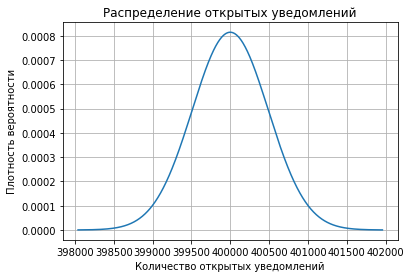

Вероятность открытия не более 399,5 тыс. уведомлений: 0.1537


In [70]:
# Заданные значения
n_notifications = 1000000  # Количество разосланных уведомлений
p_open = 0.4               # Вероятность открытия уведомления

# Вычисление параметров нормальной аппроксимации
mean = n_notifications * p_open
std_dev = np.sqrt(n_notifications * p_open * (1 - p_open))

# График нормального распределения
x = np.linspace(mean - 4 * std_dev, mean + 4 * std_dev, 1000)
pdf = norm.pdf(x, loc=mean, scale=std_dev)
plt.plot(x, pdf)
plt.xlabel('Количество открытых уведомлений')
plt.ylabel('Плотность вероятности')
plt.title('Распределение открытых уведомлений')
plt.grid(True)
plt.show()

# Оценка вероятности открытия не более 399,5 тыс. уведомлений
result = norm.cdf(399500, loc=mean, scale=std_dev)
print("Вероятность открытия не более 399,5 тыс. уведомлений: {:.4f}".format(result))

***Вероятность открытия не более 399,5 тыс. уведомлений составляет примерно 15.37%. Это означает, что с вероятностью около 15.37% количество открытых уведомлений не превысит 399,5 тыс. пользователей.***

### **<p style="text-align: center;">Итоговый вывод. </p>**
 Задача проекта проанализировать популярный сервис аренды самокатов GoFast,для этого было сделано следующее:

- Проверили данные за какой период у нас имеются. Данные о сервисе аренды самокатов GoFast представленны за 2021 год.
- Изучили общую информацию о каждом датафрейме,пропущенные значения в столбцах отсутствуют. Найден 31 дубликат в датафреймах,данные дубликаты удалили.

***Исходя из предоставленной информации о количестве пользователей сервиса аренды самокатов GoFast в разных городах, можно сделать следующие выводы:*** Пятигорск является наиболее популярным городом среди пользователей GoFast, с 219 пользователями.Екатеринбург занимает второе место по популярности с 204 пользователями.Ростов-на-Дону, Краснодар, Сочи, Омск, Тюмень и Москва также имеют значительное количество пользователей, хотя и ниже по сравнению с Пятигорском и Екатеринбургом. Можно заключить, что сервис аренды самокатов GoFast пользуется спросом в разных городах, и есть потенциал для расширения и увеличения покрытия в других городах.

***Исходя из предоставленных данных о соотношении пользователей с подпиской Ultra и без подписки, можно сделать следующие выводы:*** Большинство пользователей (54,4%) не имеют подписки на сервис аренды самокатов GoFast.
Пользователи с подпиской Ultra составляют 45,6% от общего числа пользователей.Эти данные могут указывать на потенциал для увеличения числа пользователей с подпиской. Бизнесу может быть выгодно провести дополнительные маркетинговые и промоциональные мероприятия, чтобы привлечь больше пользователей к использованию подписки и повысить ее привлекательность. 

***Исходя из данных о возрасе пользователей,*** можно сделать вывод, что большинство пользователей сервиса аренды самокатов GoFast находятся в возрастном диапазоне от 20 до 30 лет. Однако также есть пользователи моложе 20 лет и старше 30 лет, что указывает на разнообразие возрастных групп пользователей. Эта информация может быть полезной для определения целевой аудитории и разработки маркетинговых стратегий, учитывающих возрастные особенности пользователей.

Проверили некоторые гипотезы, которые могут помочь бизнесу вырасти.

Проверив гипотезы были сделаны следующие выводы:

- Пользователи с подпиской тратят больше времени на поездки. Таким образом, можно сделать вывод, что пользователи с подпиской могут быть выгоднее для компании, так как они тратят больше времени на поездки.

- Нет статистических доказательств того, что расстояние, которое проезжают пользователи с подпиской за одну поездку, превышает 3130 метров.
- Нет статистических доказательств того, что помесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки."
